## File to prepare high-res ship images for SwinIR fine-tuning, as well as a dummy images for initial testing

In [1]:
import os
from PIL import Image
import pillow_avif
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show
from rasterio.windows import Window

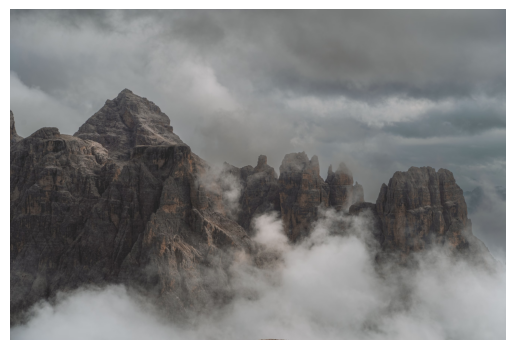

In [5]:
# Plot high-res test test image
high_res_test_image_path = os.path.join("/Users", "alexm", "Senior-Design", "swin_ir_finetuning", "test_dataset", "test_img.avif")
test_img = Image.open(high_res_test_image_path).convert("RGB")
plt.imshow(test_img)
plt.axis("off")
plt.show()

In [20]:
print("Image shape is:", test_img.size)

Image shape is: (5340, 3560)


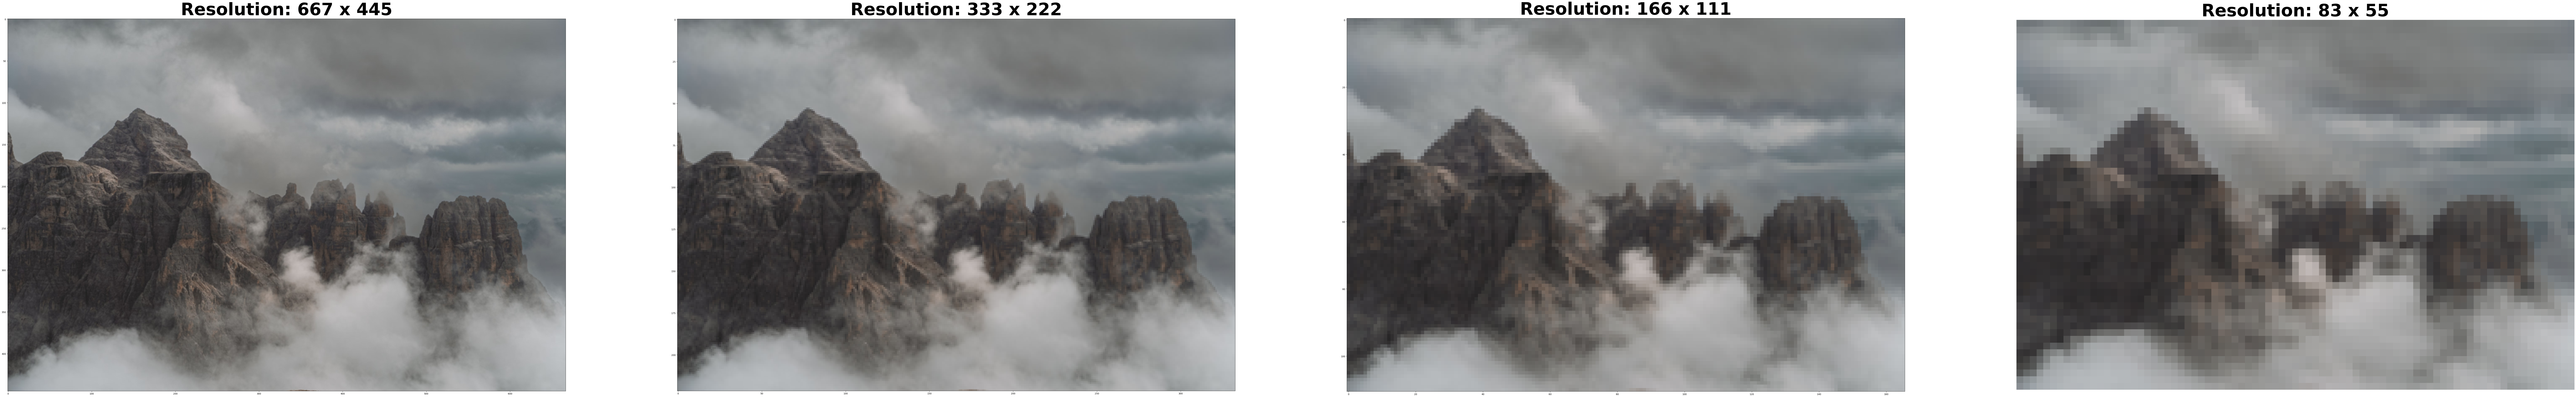

In [7]:
# Down-sample high-res test image by different factors, plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(200,400))
for i, down_factor in enumerate([8,16,32,64]):
    test_img_low_res = test_img.resize((5340 // down_factor, 3560 // down_factor))
    axs[i].imshow(test_img_low_res)
    axs[i].set_title("Resolution: " + str(5340 // down_factor) + " x " + str(3560 // down_factor), fontdict={'fontsize': 75, 'fontweight': 'bold'})
    plt.axis("off")
plt.show()

In [8]:
# Save the 16x downsampled image as high-res, 64x downsampled as low-res
high_res_test_image_path = os.path.join("/Users", "alexm", "Senior-Design", "swin_ir_finetuning", "test_dataset", "high_res", "1.jpg")
low_res_test_image_path = os.path.join("/Users", "alexm", "Senior-Design", "swin_ir_finetuning", "test_dataset", "low_res", "1.jpg")
high_res_img = test_img.resize((5340 // 16, 3560 // 16))
low_res_img = test_img.resize((5340 // 64, 3560 // 64))
high_res_img.save(high_res_test_image_path, "JPEG", quality=85)
low_res_img.save(low_res_test_image_path, "JPEG", quality=85)

## SwinIR: Using bounding box labels, extract patches from the full image with ships in them, then save images

In [10]:
root_image_dir = os.path.join("/Users", "alexm", "Senior-Design", "umbra_ship_detection_images")
label_file_path = os.path.join(root_image_dir, "testUMBRA_confirmed_detections.txt")

In [11]:
def bbox_to_bigger_window(upper_left, lower_right, full_image_shape, aspect_ratio=0.15):
    x1, y1 = upper_left
    x2, y2 = lower_right
    width = x2 - x1
    height = y2 - y1
    new_width = round((1/aspect_ratio) * width)
    new_height = round((1/aspect_ratio) * height)
    x1_new = round(x1 - (0.5*(new_width - width)))
    y1_new = round(y1 - (0.5*(new_height - height)))
    # Clamp coordinates to within full image
    if x1_new < 0:
        x1_new = 0
    if y1_new < 0:
        y1_new = 0 
    if x1_new + new_width > full_image_shape[0]:
        new_width = round(full_image_shape[0] - x1_new)
    if y1_new + new_height > full_image_shape[1]:
        new_height = round(full_image_shape[1] - y1_new)
    return x1_new, y1_new, new_width, new_height

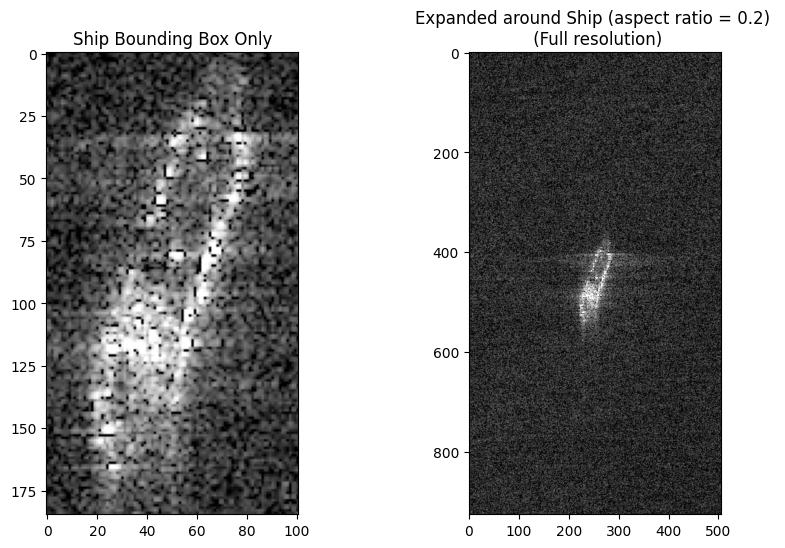

In [16]:
# First, plot an example of what the images will look like (just ship, expanded around ship in high-res, expanded around ship in low-res)
# Loop through each line (label) in label file
aspect_ratio = 0.2
med_downsample_factor = 2
downsample_factor = 8
with open(label_file_path, 'r') as file:
    for idx, line in enumerate(file):
        values = line.strip().split(',')
        # Extract info
        img_name = values[0]
        upper_left_coords = (float(values[1]), float(values[2]))
        lower_right_coords = (float(values[3]), float(values[4]))
        # Load full image
        full_img_path = os.path.join(root_image_dir, "tif-images", "sar-data", "tasks", "ship_detection_testdata", img_name + "_GEC.tif")
        if idx == 175:
            with rasterio.open(full_img_path) as vv_src:
                x1_new, y1_new, new_width, new_height = bbox_to_bigger_window(upper_left_coords, lower_right_coords, vv_src.shape, aspect_ratio)
                window_small = Window(col_off=upper_left_coords[0], row_off=upper_left_coords[1], width=lower_right_coords[0]-upper_left_coords[0], height=lower_right_coords[1]-upper_left_coords[1])
                window_big = Window(col_off=x1_new, row_off=y1_new, width=new_width, height=new_height)
                subimg_small = vv_src.read(1, window=window_small)
                subimg_big = vv_src.read(1, window=window_big)
            # Convert to PIL-compatible images
            subimg_small = Image.fromarray(subimg_small)
            subimg_big_high_res = Image.fromarray(subimg_big)
            #subimg_big_med_res = subimg_big_high_res.resize((subimg_big_high_res.size[0] // med_downsample_factor, subimg_big_high_res.size[1] // med_downsample_factor))
            #subimg_big_low_res = subimg_big_high_res.resize((subimg_big_high_res.size[0] // downsample_factor, subimg_big_high_res.size[1] // downsample_factor))
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
            axs[0].imshow(subimg_small, cmap='gray')
            axs[1].imshow(subimg_big_high_res, cmap='gray')
            #axs[1].imshow(subimg_big_med_res, cmap='gray')
            #axs[2].imshow(subimg_big_low_res, cmap='gray')
            axs[0].set_title("Ship Bounding Box Only")
            axs[1].set_title("Expanded around Ship (aspect ratio = 0.2) \n (Full resolution)")
            #axs[2].set_title("Expanded around Ship (aspect ratio = 0.2) \n (Low-res, downsampled by 8x)")
            plt.show()
            break

In [17]:
# Loop through each line (label) in label file, extract patch, save high-res image
aspect_ratio = 0.2
#med_downsample_factor = 2
#downsample_factor = 8
high_res_images_folder = os.path.join(root_image_dir, "ship_patches_high_res")
#low_res_images_folder = os.path.join(root_image_dir, "ship_patches_low_res")
save_count = 0
with open(label_file_path, 'r') as file:
    for line_idx, line in enumerate(file):
        values = line.strip().split(',')
        # Extract info
        img_name = values[0]
        upper_left_coords = (float(values[1]), float(values[2]))
        lower_right_coords = (float(values[3]), float(values[4]))
        # Load full image
        full_img_path = os.path.join(root_image_dir, "tif-images", "sar-data", "tasks", "ship_detection_testdata", img_name + "_GEC.tif")
        try:
            with rasterio.open(full_img_path) as vv_src:
                x1_new, y1_new, new_width, new_height = bbox_to_bigger_window(upper_left_coords, lower_right_coords, vv_src.shape, aspect_ratio)
                window_small = Window(col_off=upper_left_coords[0], row_off=upper_left_coords[1], width=lower_right_coords[0]-upper_left_coords[0], height=lower_right_coords[1]-upper_left_coords[1])
                window_big = Window(col_off=x1_new, row_off=y1_new, width=new_width, height=new_height)
                subimg_small = vv_src.read(1, window=window_small)
                subimg_big = vv_src.read(1, window=window_big)
            # Convert to PIL-compatible images
            subimg_small = Image.fromarray(subimg_small)
            subimg_big_high_res = Image.fromarray(subimg_big)
            #subimg_big_med_res = subimg_big_high_res.resize((subimg_big_high_res.size[0] // med_downsample_factor, subimg_big_high_res.size[1] // med_downsample_factor))
            #subimg_big_low_res = subimg_big_high_res.resize((subimg_big_high_res.size[0] // downsample_factor, subimg_big_high_res.size[1] // downsample_factor))
            # Save med-res and low-res images
            save_img_name = f"{img_name}_{line_idx}.jpg"
            high_res_image_path = os.path.join(high_res_images_folder, save_img_name)
            #low_res_image_path = os.path.join(low_res_images_folder, save_img_name)
            subimg_big_high_res.save(high_res_image_path, "JPEG")
            #subimg_big_med_res.save(high_res_image_path, "JPEG")
            #subimg_big_low_res.save(low_res_image_path, "JPEG")
            save_count += 1
        except:
            pass
            #print("Pass!")  # Ignore few images where ship is right on border of full image
print("Num saved:", save_count)

Num saved: 352


### Move 85% of images to training folders, 15% of images to testing folders

In [18]:
import random
import shutil

In [19]:
random.seed(42)

#low_res_folder = os.path.join(root_image_dir, "ship_patches_low_res")
high_res_folder = os.path.join(root_image_dir, "ship_patches_high_res")

#low_res_train_folder = os.path.join(root_image_dir, "ship_patches_low_res_train")
high_res_train_folder = os.path.join(root_image_dir, "ship_patches_high_res_train")
#low_res_test_folder = os.path.join(root_image_dir, "ship_patches_low_res_test")
high_res_test_folder = os.path.join(root_image_dir, "ship_patches_high_res_test")

# Get a list of all file names in the low-res folder.
filenames = os.listdir(high_res_folder)

# Determine the number of files that represent 15% of the data
total_files = len(filenames)
test_count = int(total_files * 0.15) 

# Randomly select test files
test_files = random.sample(filenames, test_count)

# Create the training file list by filtering out the test files
train_files = [f for f in filenames if f not in test_files]

# Now, copy the selected files into the appropriate test folders
for f in test_files:

    #low_res_src = os.path.join(low_res_folder, f)
    high_res_src = os.path.join(high_res_folder, f)
    #low_res_dst = os.path.join(low_res_test_folder, f)
    high_res_dst = os.path.join(high_res_test_folder, f)

    #shutil.copy(low_res_src, low_res_dst)
    shutil.copy(high_res_src, high_res_dst)

# Copy the remaining files into the train folders
for f in train_files:
    #low_res_src = os.path.join(low_res_folder, f)
    high_res_src = os.path.join(high_res_folder, f)
    
    #low_res_dst = os.path.join(low_res_train_folder, f)
    high_res_dst = os.path.join(high_res_train_folder, f)
    
    #shutil.copy(low_res_src, low_res_dst)
    shutil.copy(high_res_src, high_res_dst)